In [1]:
import pandas as pd
import sys
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
matplotlib.rcParams['figure.figsize'] = [14, 8]

In [3]:
aaconv = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M',
     'H1S': 'H', 'H2S': 'H'}

In [4]:
# load mutation database 
mutationlist = pd.read_excel("../Data/Mutations_database/FH_mutations_DB.xlsx")

In [5]:
# same as before - process the mutations
mutationlist_only = pd.DataFrame(mutationlist["Protein Change"])

In [6]:
mutationlist_only['A'], mutationlist_only['Mutation'] = mutationlist_only['Protein Change'].str.split('p.', 1).str

In [7]:
mutationlist_only = mutationlist_only[mutationlist_only["Mutation"] != "?"]
mutationlist_only = mutationlist_only[mutationlist_only["Mutation"] != "(=)"]
mutationlist_only["Mutation"] = mutationlist_only.apply(lambda x: x["Mutation"][1:-1], axis =1)
mutationlist_only = mutationlist_only[~mutationlist_only.Mutation.str.contains("\*")]
mutationlist_only = mutationlist_only[~mutationlist_only.Mutation.str.contains("dup")]
mutationlist_only = mutationlist_only[~mutationlist_only.Mutation.str.contains("del")]

In [8]:
mutationlist_only["AAfrom"] = mutationlist_only.apply(lambda x: x["Mutation"][:3], axis =1)
mutationlist_only["AAto"] = mutationlist_only.apply(lambda x: x["Mutation"][-3:], axis =1)
mutationlist_only["Residue"] = mutationlist_only.apply(lambda x: int(x["Mutation"][3:-3]), axis =1)
mutationlist_only = mutationlist_only[mutationlist_only["Residue"] >= 49]
mutationlist_only["AAfrom"] = mutationlist_only["AAfrom"].apply(lambda x: aaconv.get((x.upper())))
mutationlist_only["AAto"] = mutationlist_only["AAto"].apply(lambda x: aaconv.get((x.upper())))

In [9]:
mutationlist_only["Mutation"] = mutationlist_only.apply(lambda x: "%s%s%s" % (x["AAfrom"], (x["Residue"]), x["AAto"] ), axis =1)


In [10]:
mutationlist_original = []
for item in mutationlist_only["Mutation"]:
    mutationlist_original.append(item)

In [11]:
mutationlist = mutationlist_original

In [12]:
mutationlistint = []
for item in mutationlist:
    mutationlistint.append(int(item[1:-1]))

In [13]:
mutationcountlist = []
for x in range(49, 510):
    counter = mutationlistint.count(x)
    mutationcountlist.append([int(x), counter])

In [14]:
mutationcount = pd.DataFrame.from_records(mutationcountlist)

In [15]:
mutationcount.columns= ["Residue", "Mutnumber"]

In [16]:
# read the full array of mutation energy data
combined_dataarray = pd.read_csv("../Data/Structure_data/FH_complete_mutation_summary.csv")

In [17]:
def plotrec(x1, x2, y, name, color):
    width = abs(x2-x1)
    height = 2
    ax_middle.add_patch(patches.Rectangle([x1, y], width, height, lw = 2, facecolor = color, edgecolor = "k", zorder = 2))
    ax_middle.annotate(name, [x1+40,y-1.75], size = 12, ha = "center")

In [21]:
FH_subunits = {"D1 Subunit": [50, 188, "#43A9DB"], "D2 Subunit": [189, 439, "#FB4459"], "D3 Subunit": [440, 509, "#FFFC79"]}


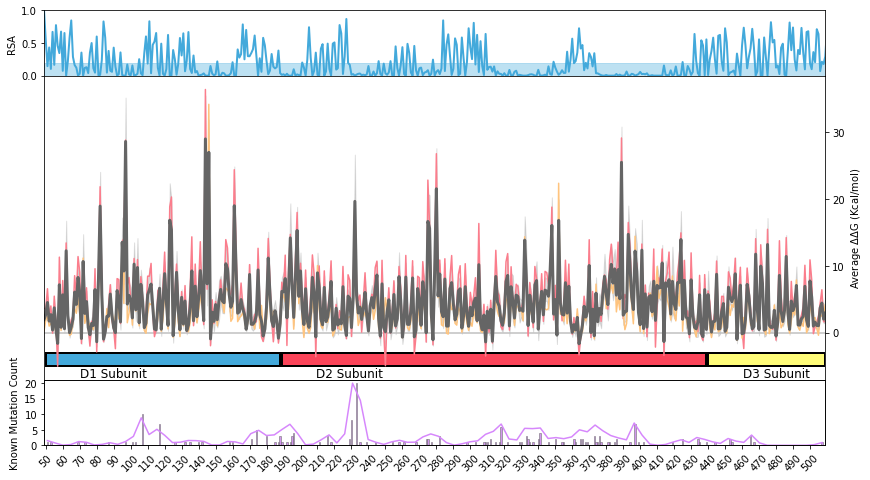

In [22]:
f, (ax_top, ax_middle, ax_bottom) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.15, .7, .15)})
f.subplots_adjust(hspace = 0)
plt.xticks(rotation=45)

sns.countplot(mutationlistint, ax = ax_bottom, color="#D687FC", order = list(range(0,510)), linewidth = 0.5, edgecolor = "#656565")
ax_bottom_twin = ax_bottom.twinx()
sns.kdeplot(mutationlistint, ax = ax_bottom_twin, color="#D687FC", bw = 0.025)
ax_bottom_twin.set_yticks([])

ax_middle.set(xlim = (49,509))

ax_middle.axhline(0, color = "#C0C0C0")
ax_middle.yaxis.tick_right()
ax_middle.yaxis.set_label_position("right")
sns.lineplot(x = combined_dataarray["Residue"], y= combined_dataarray["Rosetta_energy"], color = "#FB7D8C", ci = None, ax = ax_middle)
sns.lineplot(x = combined_dataarray["Residue"], y= combined_dataarray["Foldx_energy"], color = "#FFC47E", ci = None, ax = ax_middle)
sns.lineplot(x = combined_dataarray["Residue"], y = combined_dataarray["average_energy"],lw = 3, color = "#656565", ax = ax_middle)

sns.lineplot(x = combined_dataarray["Residue"], y = combined_dataarray["RSA"], lw =2, color = "#43A9DB", ax = ax_top, ci = None )
ax_top.set_yticks([0,0.5, 1])
ax_top.set(ylim = (0,1))
ax_top.axhspan(0, 0.2, alpha=0.5, color='#7CC4E7')
ax_bottom.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
ax_bottom.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax_bottom.set_yticks([0,5,10,15,20])
ax_top.set_ylabel("RSA")
ax_middle.set_ylabel("Average $\Delta \Delta$G (Kcal/mol)")
ax_bottom.set_ylabel("Known Mutation Count")

for key, residues in FH_subunits.items():
    plotrec(residues[0],residues[1], -5, key, residues[2])
plt.savefig("Figure3_A_mutationenergyplot.png", dpi = 300)